In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit

In [173]:
df = pd.read_csv("Testapp\SwimDataTop50.csv")

In [174]:
# Function to parse time strings with variable formats
def parse_custom_time(time_str):
    time_parts_count = len(str(time_str).split(":"))
    format_map = {1: '00:00:{}', 2: '00:{}', 3: '{}'}

    if time_parts_count in format_map:
        return pd.to_timedelta(format_map[time_parts_count].format(time_str))
    else:
        raise ValueError(f'Invalid time format: {time_str}')

# Convert 'time' column to timedelta 
df['time'] = df['time'].apply(parse_custom_time)

# Calculate 'time_seconds' and 'speed' columns
df.loc[:, 'time_seconds'] = df['time'].dt.total_seconds()
df.loc[:, 'speed'] = df['distance'] / df['time_seconds']

df["firstname"] = df['firstname'].str.lower()

# Remove duplicates
df.drop_duplicates(subset=['surname', 'firstname', 'distance', 'technique', 'track length'], keep='first', inplace=True)

,surname,firstname,distance,technique,track length,time,time_seconds,speed
0,MCEVOY,cameron,50,Freistil,50,0 days 00:00:21.060000,21.06,2.374169
1,MCEVOY,cameron,50,Freistil,25,0 days 00:00:20.750000,20.75,2.409639
2,MCEVOY,cameron,100,Freistil,50,0 days 00:00:47.040000,47.04,2.125850
3,MCEVOY,cameron,100,Freistil,25,0 days 00:00:46.190000,46.19,2.164971
4,MCEVOY,cameron,200,Freistil,50,0 days 00:01:45.460000,105.46,1.896454
...,...,...,...,...,...,...,...,...
1697,BOUSQUET,frederick,50,Freistil,25,0 days 00:00:20.520000,20.52,2.436647
1698,BOUSQUET,frederick,100,Freistil,50,0 days 00:00:47.150000,47.15,2.120891
1699,BOUSQUET,frederick,100,Freistil,25,0 days 00:00:45.880000,45.88,2.179599
1700,BOUSQUET,frederick,200,Freistil,50,0 days 00:01:51.440000,111.44,1.794688


In [175]:
def fit_rational_function(x, a, b, c):
    return 1 / (a * x + b) + c

In [176]:
#constants
DISTANCE_200 = 200
TRACK_LENGTHS = [25, 50]
TECHNIQUES = ['F', 'R', 'B', 'S', 'L']
TECHNIQUE_MAP = {
    'F': 'Freistil',
    'R': 'Rücken',
    'B': 'Brust',
    'S': 'Schmetterling',
    'L': 'Lagen'
}

In [207]:
# Function to filter data for a specific swimmer and plot the rational function fit
def plot_rational_function_for_swimmer(df, firstname, lastname, track_length, technique, isAbsolute=False):

    # Validate parameters
    if not firstname or not lastname or not track_length or not technique:
        raise ValueError('Invalid request. Please provide all parameters.')
    elif technique not in TECHNIQUES:
        raise ValueError('Invalid request. Technique must be one of F, R, B, S, L.')
    elif track_length not in TRACK_LENGTHS:
        raise ValueError('Invalid request. Track length must be one of 25, 50.')

    lastname = lastname.upper()
    firstname = firstname.lower()
    
    # Lists to store predicted and measured values
    measured_values = {}
    predicted_values = {}

    # Map the technique
    technique = TECHNIQUE_MAP[technique]

    # Filter the DataFrame based on the provided parameters
    filtered_df = df[(df['firstname'] == firstname) & (df['surname'] == lastname) & (df['track length'] == int(track_length)) & (df['technique'] == technique)]

   # If no data found, return an error message
    if filtered_df.empty:
        raise ValueError(f'No data found for {firstname} {lastname}.')S
    elif len(filtered_df) < 3:
        raise ValueError(f'Not enough data found for {firstname} {lastname}.')
    
    if not isAbsolute:
        # Check if 200m distance is present in the filtered data
        if DISTANCE_200 in filtered_df['distance'].unique():
            # If 200m distance is present, use the speed value for division
            divisor = filtered_df[filtered_df['distance'] == DISTANCE_200]['speed'].values[0]
        else:
            # If 200m distance is not present, find the closest distance and use its speed value for division
            closest_distance_index = (filtered_df['distance'] - 200).abs().argsort().sort_values()[:1].index
            divisor = filtered_df.loc[closest_distance_index, 'speed'].values[0]

        # Calculation for relative speed to 200m
        filtered_df.loc[:,'speed'] = filtered_df['speed'] / divisor


    # Fit a rational function to the filtered data
    try:
        params, covariance = curve_fit(fit_rational_function, filtered_df['distance'], filtered_df['speed'], method="dogbox",maxfev=500000)
    except RuntimeError:
        raise RuntimeError('Curve fitting failed.')
        
    x_range = np.linspace(0, 2000, 200)
    y_pred = fit_rational_function(x_range, *params)

    for X, Y in zip(x_range, y_pred):
        predicted_values[X] = Y

    for distance, speed in zip(filtered_df['distance'], filtered_df['speed']):
        measured_values[distance] = speed

    # Create a JSON response containing predicted and measured values
    data = {
        "pred_values": predicted_values,
        "mes_values": measured_values
    }
    return data


C:\Users\lukas\AppData\Local\Temp\ipykernel_15724\2690336672.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:,'speed'] = filtered_df['speed'] / divisor


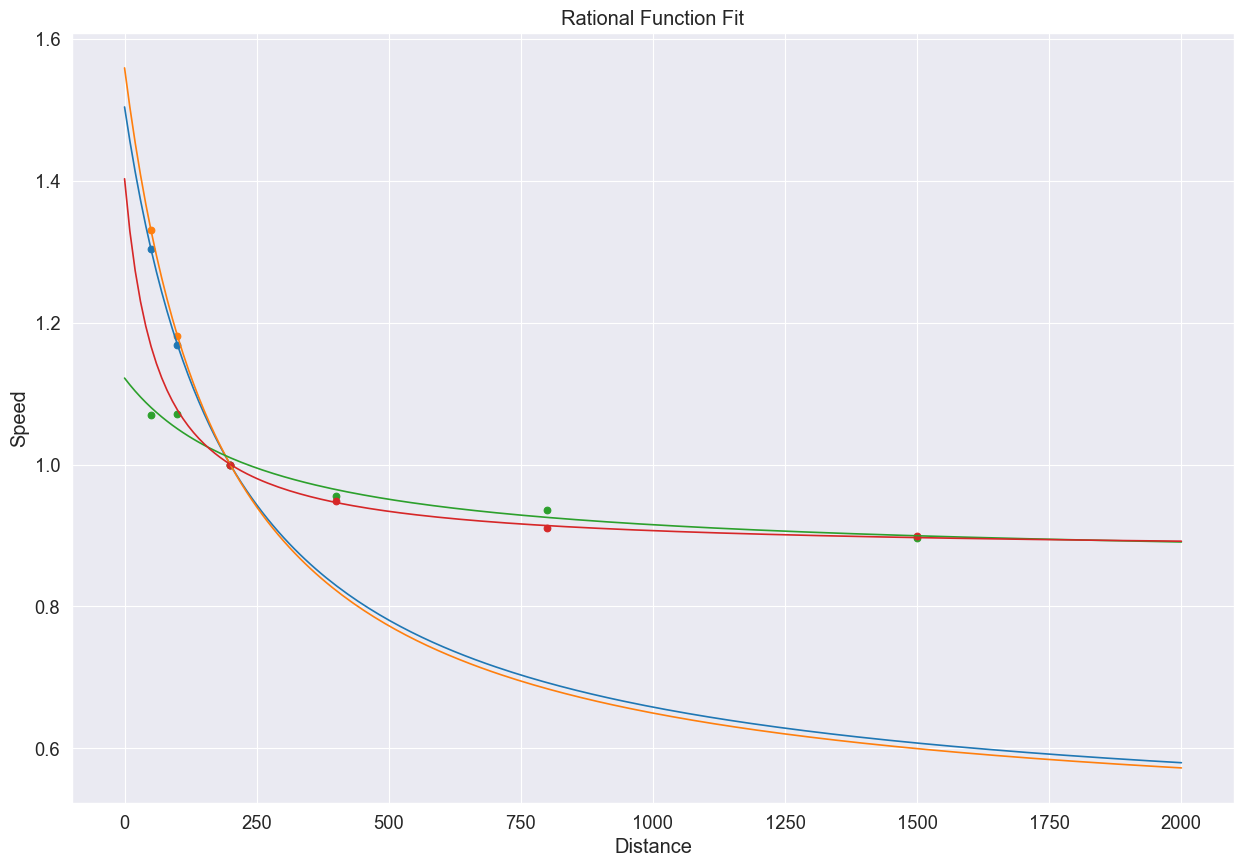

In [213]:
plt.figure(figsize=(15, 10))
plt.title('Rational Function Fit')
plt.xlabel('Distance')
plt.ylabel('Speed')
sns.set_style("darkgrid")
sns.set_context("paper", font_scale=1.5)

sprint = plot_rational_function_for_swimmer(df, firstname='Cesar', lastname='CIELO', track_length=25, technique='F')
plt.plot(sprint['pred_values'].keys(), sprint['pred_values'].values(), label='Sprint')
plt.scatter(sprint['mes_values'].keys(), sprint['mes_values'].values(), label='Sprint')
sprint = plot_rational_function_for_swimmer(df, firstname='Frederick', lastname='BOUSQUET', track_length=50, technique='F')
plt.plot(sprint['pred_values'].keys(), sprint['pred_values'].values(), label='Sprint')
plt.scatter(sprint['mes_values'].keys(), sprint['mes_values'].values(), label='Sprint')
sprint = plot_rational_function_for_swimmer(df, firstname='Lin', lastname='ZHANG', track_length=50, technique='F')
plt.plot(sprint['pred_values'].keys(), sprint['pred_values'].values(), label='Sprint')
plt.scatter(sprint['mes_values'].keys(), sprint['mes_values'].values(), label='Sprint')
sprint = plot_rational_function_for_swimmer(df, firstname='Yang', lastname='SUN', track_length=50, technique='F')
plt.plot(sprint['pred_values'].keys(), sprint['pred_values'].values(), label='Sprint')
plt.scatter(sprint['mes_values'].keys(), sprint['mes_values'].values(), label='Sprint')